# Gaussian Process from Scratch
* choose theta and beta hyperparameters
* large beta (>=1e10) is equivalent to noiseless case of GP

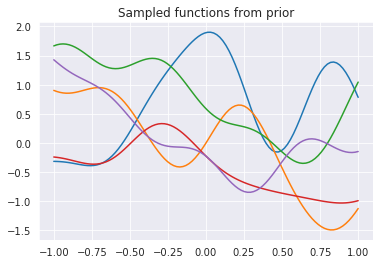

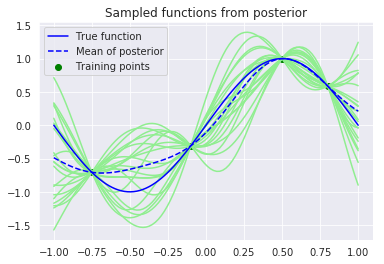

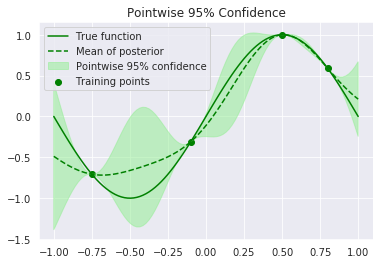

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

class kernel():
    def __init__(self, theta):
        self.theta0 = theta[0] 
        self.theta1 = theta[1]
        self.theta2 = theta[2]
        self.theta3 = theta[3]
        
    def evaluate(self, x1, x2):
        x1, x2 = np.array(x1), np.array(x2)
        return self.theta0*np.exp(-(self.theta1/2)*np.linalg.norm(x1-x2)**2) + self.theta2 + self.theta3*np.sum(x1*x2)

myKernel = kernel([1,10,0,0])
beta = 1e10

pts = np.linspace(-1,1,100)
cov = np.zeros((100,100))
for i,x1 in enumerate(pts):
    for j,x2 in enumerate(pts):
        cov[i,j] = myKernel.evaluate(x1, x2)


sample_funcs = np.random.multivariate_normal(np.zeros(100), cov, 5)
for func in sample_funcs:
    sns.lineplot(pts, func)
plt.title('Sampled functions from prior')
plt.show()
# plt.savefig('figures/gp_prior.png', dpi=200)

# Let's create a sine function and collect some test points
def func(x):
    return np.sin(np.pi*x)


Y_true = func(pts)
x_train =  np.array([-0.75,-0.1,0.5,0.8])
t_train = func(x_train) + np.random.normal(0, 1/np.sqrt(beta), x_train.shape[0])

# posterior distribution
num_train_pts, num_test_pts, tot_pts = x_train.shape[0], pts.shape[0], x_train.shape[0]+pts.shape[0]
all_pts = np.concatenate((x_train, pts))
C_full = np.zeros((tot_pts, tot_pts))
for i,x1 in enumerate(all_pts):
    for j,x2 in enumerate(all_pts):
        C_full[i,j] = myKernel.evaluate(x1, x2)

Cn = C_full[:num_train_pts, :num_train_pts]+np.eye(num_train_pts)/beta
k = C_full[:num_train_pts, num_train_pts:]
c = C_full[num_train_pts:, num_train_pts:]+np.eye(num_test_pts)/beta

kTCinv = np.matmul(k.T, np.linalg.inv(Cn))
Mu = np.matmul(kTCinv,t_train)
Sigma = c-np.matmul(kTCinv, k)

sample_funcs = np.random.multivariate_normal(Mu, Sigma, 20)
# sample_funcs = pd.DataFrame(data=sample_funcs.T, index=[str(i) for i in range(num_test_pts)])
for func in sample_funcs:
    sns.lineplot(pts, func, color='lightgreen')
sns.lineplot(pts, Y_true, color='blue', label='True function')
plt.plot(pts, Mu, color='blue', linestyle='--', label='Mean of posterior')
plt.scatter(x_train, t_train, marker='o', color='green', label='Training points')
plt.legend()
plt.title('Sampled functions from posterior')
plt.show()


sns.lineplot(pts, Y_true, color='green', label='True function')
plt.plot(pts, Mu, color='green', linestyle='--', label='Mean of posterior')
plt.scatter(x_train, t_train, marker='o', color='green', label='Training points')
plt.legend()
plt.title('Pointwise 95% Confidence')
x_coors = np.concatenate((pts, pts[::-1]))
sigma_diag = np.diagonal(Sigma)
y_coors = np.concatenate((Mu-1.96*sigma_diag, (Mu+1.96*sigma_diag)[::-1]))
plt.fill(x_coors, y_coors, color='lightgreen', alpha=0.5, label='Pointwise 95% confidence')
plt.legend()
plt.show()